<h1>Experimentos de Hiper-parâmetros</h1>
<p>Experimentos realizados com o objetivo de definir hiper-parâmetros para uma rede neural convolucional que seja capaz de aprender o procedimento de <b>esteganografia</b>, ou seja, escoder e revelar um arquivo binário em uma imagem digital.</p>

<h3>Importação de bibliotecas</h3>

In [ ]:
import os

In [ ]:
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import random
import math
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from skimage.metrics import mean_squared_error
from skimage.io import imshow, imread, imsave
from tqdm.notebook import tqdm, trange
import time
import string

from IPython import display

<h3>Definição da semente do gerador de números aleatórios para permitir a reprodução dos experimentos realizados</h3>

In [ ]:
os.environ['PYTHONHASHSEED']=str(456)
tf.random.set_seed(456)
np.random.seed(456)
random.seed(456)

<h3>Declaração de funções para armazenar/recuperar um arquivo binário no ruído de uma imagem</h3>

In [ ]:
# função responsável por definir quais pontos da imagem conterá o ruído da mensagem secreta
def generateMatStegano():
    mat = np.zeros((64, 64))
    
    for i in range(64):
        randIdxs = random.sample(range(0, 64), 21)
        
        for j in range(64):
            if j in randIdxs:
                mat[i][j] = 1
            
    return mat

matStegano = generateMatStegano()

In [ ]:
# Função responsável por adicionar na imagem um ruído representando a mensagem secreta
def stegano(img, msg):
    retImg = np.zeros((img.shape[0], img.shape[1], img.shape[2]))
    
    z = 0
    
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            for k in range(img.shape[2]):
                retImg[i][j][k] = img[i][j][k]

                if matStegano[i][j] == 1:
                    if msg[z] == 0:
                        retImg[i][j][k] = 0
                    else:
                        retImg[i][j][k] = 255
            
            if matStegano[i][j] == 1:
                z += 1
    
    return retImg

In [ ]:
# Função responsável por extrair a mensagem secreta do ruído da imagem
def steganoInv(img):
    msg = []
    
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if matStegano[i][j] == 1:
              media = 0

              for k in range(img.shape[2]):
                media += img[i][j][k]

              media /= img.shape[2]

              if media >= 127:
                  msg.append(1)
              else:
                  msg.append(0)
    
    msg = np.array(msg)
    
    return msg

<h3>Leitura e pré-processamento do dataset</h3>

In [ ]:
images = []

for file in os.listdir('dataset'):
    try:
        img = imread('dataset/' + file)

        if img.shape == (64, 64, 3):
          images.append(img)
    except:
        continue

images = np.array(images)

In [ ]:
images.shape

(9811, 64, 64, 3)

In [ ]:
n = images.shape[0]

In [ ]:
train_images, test_images = images[:int(n*0.75)], images[int(n*0.75):]

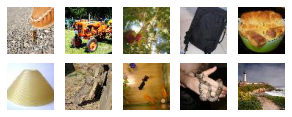

In [ ]:
fig = plt.figure(figsize=(5, 5))
for i in range(10):
  plt.subplot(5, 5, i+1)
  plt.imshow(train_images[i], cmap='gray')
  plt.axis('off')
plt.savefig('dataset_tiny_example.png')
plt.show()

In [ ]:
train_images_original = np.array(train_images, copy=True)
test_images_original = np.array(test_images, copy=True)

In [ ]:
train_images.shape

(7358, 64, 64, 3)

Geração das mensagens secretas, aplicação do código de haming para aumentar a redundancia e armazenamento da mensagem secreta nos arquivos do dataset

In [ ]:
def neededRedundantBits(m):
  for r in range(m + 1):
    if 2 ** r >= m + r + 1:
      return r
  return 0

In [ ]:
tot = 1344

secretLength = 0

for i in range(tot + 1):
  if i + neededRedundantBits(i) == tot:
    secretLength = i
    break

print(tot, secretLength)

1344 1333


In [ ]:
nHammer = tot - secretLength

In [ ]:
# Função responsável por codificar a mensagem utilizando codificação de hammer
def preparaHammerArray(mensagem, nHammerBits):
  retorno = []

  j = 0
  k = 0

  for i in range(1, len(mensagem) + nHammerBits + 1):
    if i == 2 ** j:
      retorno.append(0)
      j += 1
    else:
      retorno.append(mensagem[k])
      k += 1

  for i in range(nHammerBits):
    x = 0

    for j in range(1, len(retorno) + 1):
      if j & (1 << i) == 1 << i:
        x ^= retorno[j-1]
    
    retorno[(1<<i) - 1] = x

  return retorno

In [ ]:
# Função responsável por decodificar a mensagem utilizando codificação de hammer
def corrigeHammerArray(mensagem, nHammerBits):
  retorno = []

  j = 0

  for i in range(1, len(mensagem) + 1):
    if i == 2 ** j:
      retorno.append(0)
      j += 1
    else:
      retorno.append(mensagem[i - 1])

  for i in range(nHammerBits):
    x = 0

    for j in range(1, len(retorno) + 1):
      if j & (1 << i) == 1 << i:
        x ^= retorno[j-1]
    
    retorno[(1<<i) - 1] = x

  vet = ""

  for i in range(nHammerBits):
    vet += str(mensagem[(1<<i) - 1] ^ retorno[(1<<i) - 1])

  r = int(vet[::-1], 2)

  return r

In [ ]:
preparaHammerArray([1, 1, 1, 1], 3)

[1, 1, 1, 1, 1, 1, 1]

In [ ]:
corrigeHammerArray([1, 1, 1, 1, 1, 1, 1], 3)

0

In [ ]:
# Função responsavél po gerar uma sequencia de bits que representa uma string aleatória, simulando a sequencia de bits de arquivos .txt
def generateStrBin(secretSize):
  message = []
  
  nChar = secretSize // 8

  randomStr = ''.join(random.choice(string.ascii_uppercase + string.ascii_lowercase + string.digits) for _ in range(nChar))

  for i in randomStr:
    k = ord(i)
    for j in range(8):
      message.append(k & 1)
      k >>= 1

  while(len(message) < secretSize):
    message.append(0)

  return message

In [ ]:
# armazena as mensagens secretas no dataset de treino
train_images2 = train_images
shape = train_images2.shape
train_images = np.zeros((shape[0], shape[1], shape[2], shape[3])).astype('int')

train_messages = [];

for i in trange(train_images2.shape[0]):
    message = generateStrBin(secretLength)

    message = preparaHammerArray(message, nHammer)
        
    train_messages.append(message)
    
    train_images[i] = stegano(train_images2[i], message).astype('int')
    
train_messages = np.array(train_messages)

  0%|          | 0/7358 [00:00<?, ?it/s]

In [ ]:
# armazena as mensagens secretas no dataset de teste
test_images2 = test_images
shape = test_images2.shape
test_images = np.zeros((shape[0], shape[1], shape[2], shape[3])).astype('int')

test_messages = [];

for i in trange(test_images2.shape[0]):
    message = generateStrBin(secretLength)

    message = preparaHammerArray(message, nHammer)
        
    test_messages.append(message)
    
    test_images[i] = stegano(test_images2[i], message)
    
test_messages = np.array(test_messages)

  0%|          | 0/2453 [00:00<?, ?it/s]

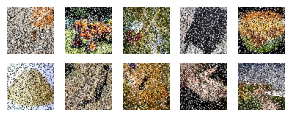

In [ ]:
fig = plt.figure(figsize=(5, 5))
for i in range(10):
  plt.subplot(5, 5, i+1)
  plt.imshow(train_images[i], cmap='gray')
  plt.axis('off')
plt.savefig('dataset_tiny_noisy.png')
plt.show()

In [ ]:
train_images = train_images.astype('float32') / 255.
test_images = test_images.astype('float32') / 255.
train_images_original = train_images_original.astype('float32') / 255.
test_images_original = test_images_original.astype('float32') / 255.

print (train_images.shape)
print (test_images.shape)
print (train_images_original.shape)
print (test_images_original.shape)

(7358, 64, 64, 3)
(2453, 64, 64, 3)
(7358, 64, 64, 3)
(2453, 64, 64, 3)


<h3>Definição da topologia para o encoder e decoder</h3>

In [ ]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [ ]:
inputLayer = layers.Input(shape=(64, 64, 3))

x = inputLayer

for k in range(3):
  layersList = []
  x1 = layers.Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='selu', name='conv_hid' + str(k) + '_3x3')(x)
  layersList.append(x1)
  x2 = layers.Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='selu', name='conv_hid' + str(k) + '_4x4')(x)
  layersList.append(x2)
  x3 = layers.Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='selu', name='conv_hid' + str(k) + '_5x5')(x)
  layersList.append(x3)
  x = layers.concatenate(layersList)

outputLayer = layers.Conv2D(3, (3, 3), strides = (1, 1), padding='same', activation='sigmoid', name='output_C')(x)

encoder = Model(inputs=inputLayer, outputs=outputLayer, name = 'Encoder')

In [ ]:
encoder.summary()

Model: "Encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv_hid0_3x3 (Conv2D)         (None, 64, 64, 50)   1400        ['input_1[0][0]']                
                                                                                                  
 conv_hid0_4x4 (Conv2D)         (None, 64, 64, 10)   490         ['input_1[0][0]']                
                                                                                                  
 conv_hid0_5x5 (Conv2D)         (None, 64, 64, 5)    380         ['input_1[0][0]']                
                                                                                            

In [ ]:
inputLayer = layers.Input(shape=(64, 64, 3))

x = inputLayer

for k in range(3):
  layersList = []
  x1 = layers.Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='selu', name='conv_rev' + str(k) + '_3x3')(x)
  layersList.append(x1)
  x2 = layers.Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='selu', name='conv_rev' + str(k) + '_4x4')(x)
  layersList.append(x2)
  x3 = layers.Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='selu', name='conv_rev' + str(k) + '_5x5')(x)
  layersList.append(x3)
  x = layers.concatenate(layersList)

outputLayer = layers.Conv2D(3, (3, 3), strides = (1, 1), padding='same', activation='sigmoid', name='output_S')(x)

decoder = Model(inputs=inputLayer, outputs=outputLayer, name = 'Decoder')

In [ ]:
decoder.summary()

Model: "Decoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv_rev0_3x3 (Conv2D)         (None, 64, 64, 50)   1400        ['input_2[0][0]']                
                                                                                                  
 conv_rev0_4x4 (Conv2D)         (None, 64, 64, 10)   490         ['input_2[0][0]']                
                                                                                                  
 conv_rev0_5x5 (Conv2D)         (None, 64, 64, 5)    380         ['input_2[0][0]']                
                                                                                            

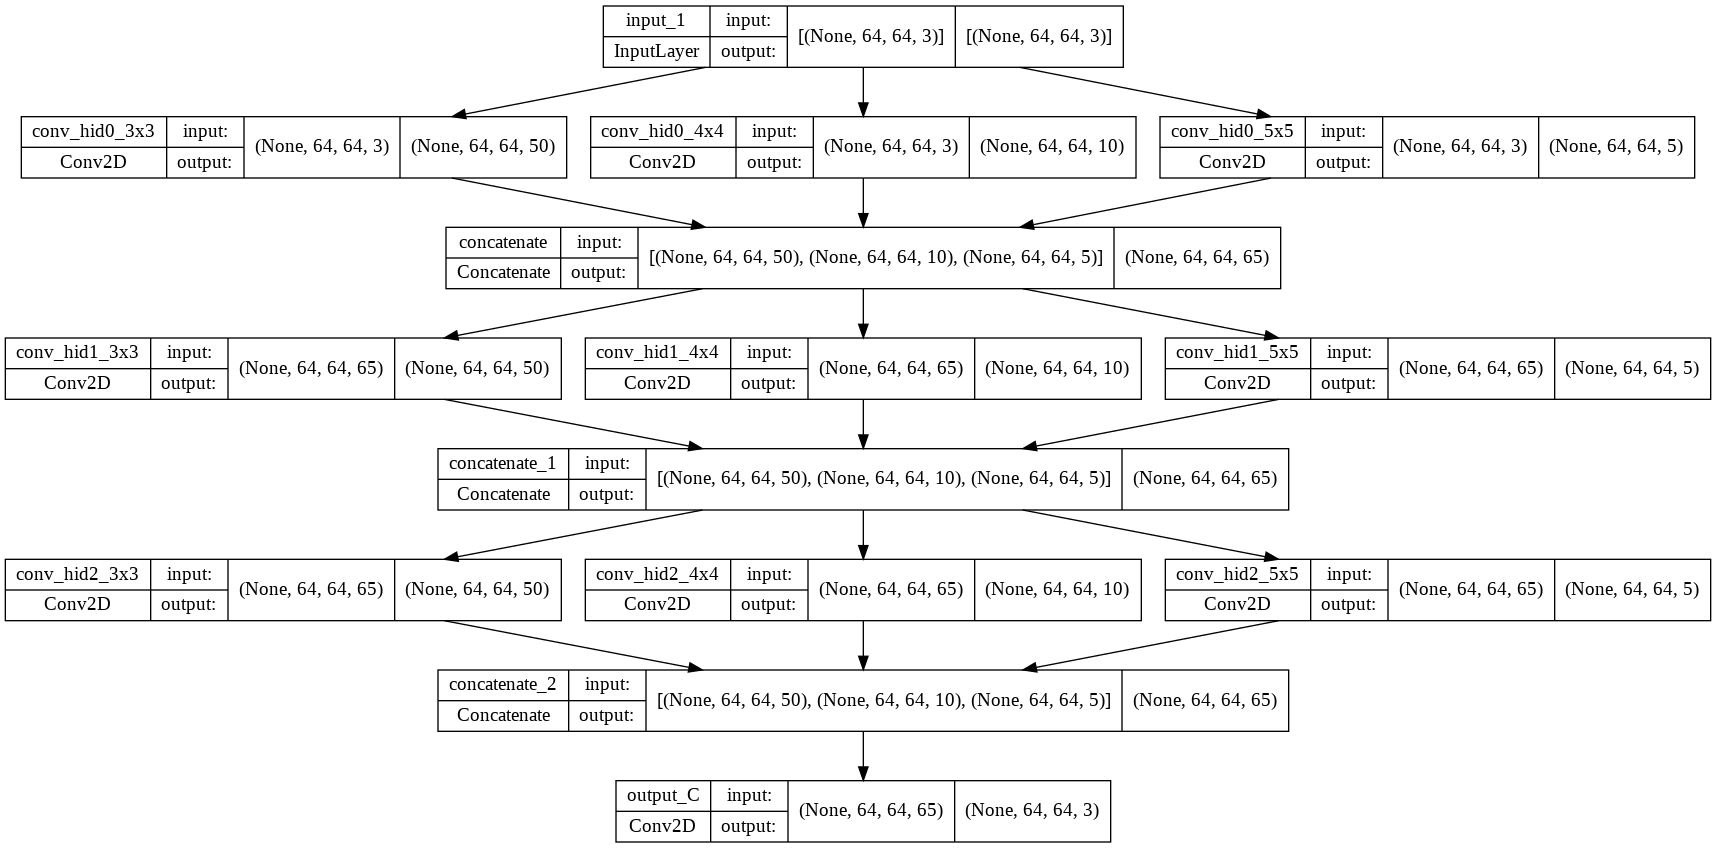

In [ ]:
tf.keras.utils.plot_model(encoder, to_file='model_encoder_' + str(i) + '.png', show_shapes=True)

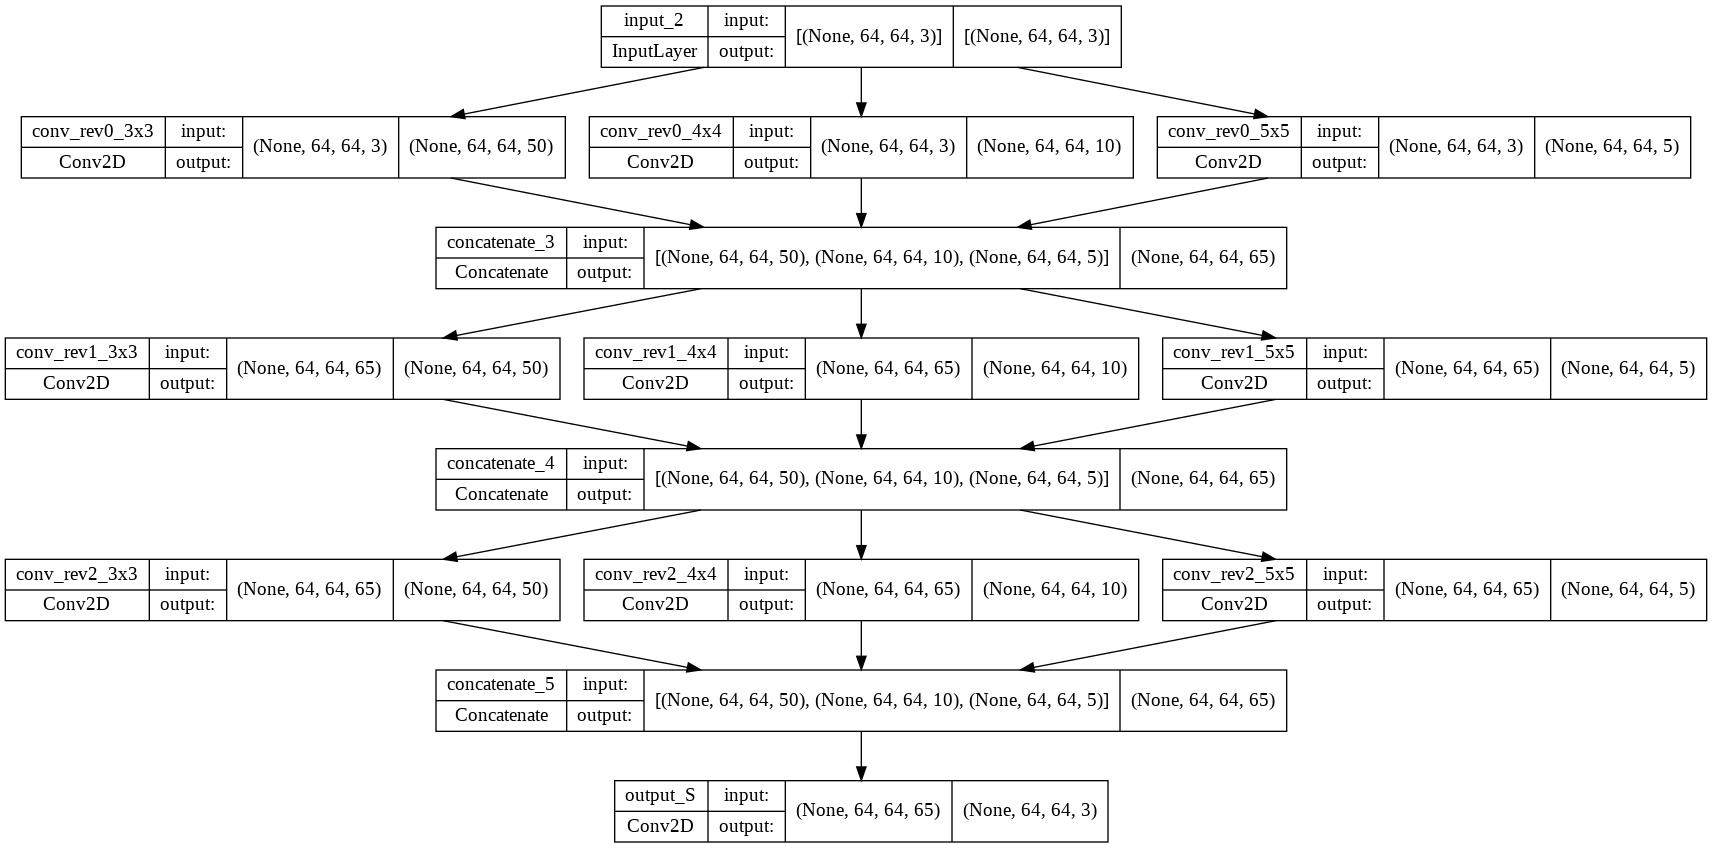

In [ ]:
tf.keras.utils.plot_model(decoder, to_file='model_decoder_' + str(i) + '.png', show_shapes=True)

<h3>Treinamento da rede neural convolucional encoder</h3>

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

In [ ]:
encoder_optimizer = tf.keras.optimizers.Adam()

In [ ]:
decoder_optimizer = tf.keras.optimizers.Adam()

In [ ]:
encoder.compile(optimizer='adam', loss=losses.MeanSquaredError())
history = encoder.fit(train_images, train_images_original,
                epochs=500,
                shuffle=False,
                callbacks=[callback],
                validation_data=(test_images, test_images_original))

Epoch 1/500
230/230 [==============================] - 18s 23ms/step - loss: 0.0228 - val_loss: 0.0161
Epoch 2/500
230/230 [==============================] - 5s 20ms/step - loss: 0.0144 - val_loss: 0.0116
Epoch 3/500
230/230 [==============================] - 5s 20ms/step - loss: 0.0107 - val_loss: 0.0100
Epoch 4/500
230/230 [==============================] - 5s 20ms/step - loss: 0.0095 - val_loss: 0.0091
Epoch 5/500
230/230 [==============================] - 5s 20ms/step - loss: 0.0089 - val_loss: 0.0084
Epoch 6/500
230/230 [==============================] - 5s 20ms/step - loss: 0.0083 - val_loss: 0.0085
Epoch 7/500
230/230 [==============================] - 5s 20ms/step - loss: 0.0078 - val_loss: 0.0075
Epoch 8/500
230/230 [==============================] - 5s 20ms/step - loss: 0.0076 - val_loss: 0.0070
Epoch 9/500
230/230 [==============================] - 5s 20ms/step - loss: 0.0073 - val_loss: 0.0076
Epoch 10/500
230/230 [==============================] - 5s 20ms/step - loss: 0.00

In [ ]:
print(history.history.keys())

dict_keys(['loss', 'val_loss'])


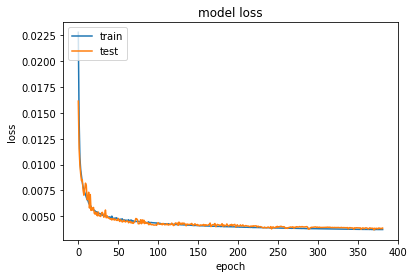

In [ ]:
legend = []

plt.plot(history.history['loss'])
legend.append('train')

plt.plot(history.history['val_loss'])
legend.append('test')

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(legend, loc='upper left')
plt.savefig('first_training.png')
plt.show()

<h3>Treinamento adversarial das redes neurais convolucionais encoder e decoder</h3>

In [ ]:
EPOCHS = 500
BATCH_SIZE = 32

In [ ]:
mseFun = losses.MeanSquaredError()

In [ ]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
#@tf.function
def train_step(images, originalImages, enc, dec, enc_opt, dec_opt):
    with tf.GradientTape() as encoder_tape, tf.GradientTape() as decoder_tape:
      encoded_images = enc(images, training=True)
      decoded_images = dec(encoded_images, training=True)

      encoded_loss = mseFun(originalImages, encoded_images)
      decoded_loss = mseFun(images, decoded_images)
      total_loss = encoded_loss + decoded_loss

    gradients_of_encoder = encoder_tape.gradient(total_loss, enc.trainable_variables)
    gradients_of_decoder = decoder_tape.gradient(decoded_loss, dec.trainable_variables)

    enc_opt.apply_gradients(zip(gradients_of_encoder, enc.trainable_variables))
    dec_opt.apply_gradients(zip(gradients_of_decoder, dec.trainable_variables))

    return total_loss

In [ ]:
def train(dataset, datasetTest, epochs, enc, dec, enc_opt, dec_opt):
  lossVet = []
  lossTestVet = []

  lastValLoss = math.inf
  nEpochsWithoutImprovement = 0

  for epoch in trange(epochs):
    start = time.time()

    lenDataset = dataset.shape[0]
    nBatches = math.floor(lenDataset / BATCH_SIZE)

    total_loss = 0

    for i in range(nBatches):
      total_loss += train_step(dataset[i:i + BATCH_SIZE], train_images_original[i:i + BATCH_SIZE], enc, dec, enc_opt, dec_opt)
    
    total_loss /= nBatches

    lossVet.append(total_loss)

    encoded_images_test = enc(datasetTest, training=False)
    decoded_images_test = dec(encoded_images_test, training=False)

    encoded_loss_test = mseFun(test_images_original, encoded_images_test)
    decoded_loss_test = mseFun(datasetTest, decoded_images_test)
    total_loss_test = encoded_loss_test + decoded_loss_test

    lossTestVet.append(total_loss_test)

    if total_loss_test >= lastValLoss + 0.001:
      nEpochsWithoutImprovement += 1

      if nEpochsWithoutImprovement == 5:
        print ('Time for epoch {} is {} sec, loss is {}, valLoss is {}, es is {}'.format(epoch + 1, time.time()-start, total_loss, total_loss_test, nEpochsWithoutImprovement))
        print("Early Stopping")
        break
    else:
      nEpochsWithoutImprovement = 0

    lastValLoss = total_loss_test

    print ('Time for epoch {} is {} sec, loss is {}, valLoss is {}, es is {}'.format(epoch + 1, time.time()-start, total_loss, total_loss_test, nEpochsWithoutImprovement))

  return lossVet, lossTestVet

In [ ]:
train_images_original.shape

(7358, 64, 64, 3)

In [ ]:
test_images = test_images[0:1000]
test_images_original = test_images_original[0:1000]

In [ ]:
history, historyTest = train(train_images, test_images, EPOCHS, encoder, decoder, encoder_optimizer, decoder_optimizer)

  0%|          | 0/500 [00:00<?, ?it/s]

Time for epoch 1 is 18.194360733032227 sec, loss is 0.03003338724374771, valLoss is 0.013228898867964745, es is 0
Time for epoch 2 is 16.774291276931763 sec, loss is 0.01092617493122816, valLoss is 0.009635593742132187, es is 0
Time for epoch 3 is 16.812243223190308 sec, loss is 0.009022409096360207, valLoss is 0.009137229062616825, es is 0
Time for epoch 4 is 16.82859778404236 sec, loss is 0.008337002247571945, valLoss is 0.009007450193166733, es is 0
Time for epoch 5 is 16.814098834991455 sec, loss is 0.007916956208646297, valLoss is 0.008627340197563171, es is 0
Time for epoch 6 is 16.774444341659546 sec, loss is 0.007488955277949572, valLoss is 0.007806462701410055, es is 0
Time for epoch 7 is 16.783719778060913 sec, loss is 0.007183669600635767, valLoss is 0.007424033246934414, es is 0
Time for epoch 8 is 16.785439491271973 sec, loss is 0.007061822339892387, valLoss is 0.007461044006049633, es is 0
Time for epoch 9 is 16.795635223388672 sec, loss is 0.006881994660943747, valLoss i

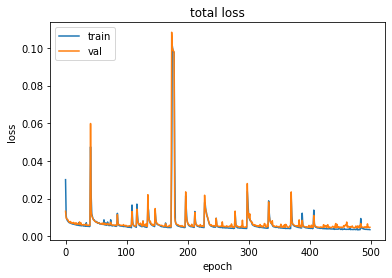

In [ ]:
legend = []
  
plt.plot(history)
legend.append('train')

plt.plot(historyTest)
legend.append('val')

plt.title('total loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(legend, loc='upper left')
plt.savefig('second_training.png')
plt.show()

<h3>Avaliação dos resultados obtidos</h3>

In [ ]:
encoded_imgs = encoder(test_images).numpy()
decoded_imgs = decoder(encoded_imgs).numpy()

encoded_imgs = encoded_imgs * 255
encoded_imgs = encoded_imgs.astype('int')

decoded_imgs = decoded_imgs * 255
decoded_imgs = decoded_imgs.astype('int')

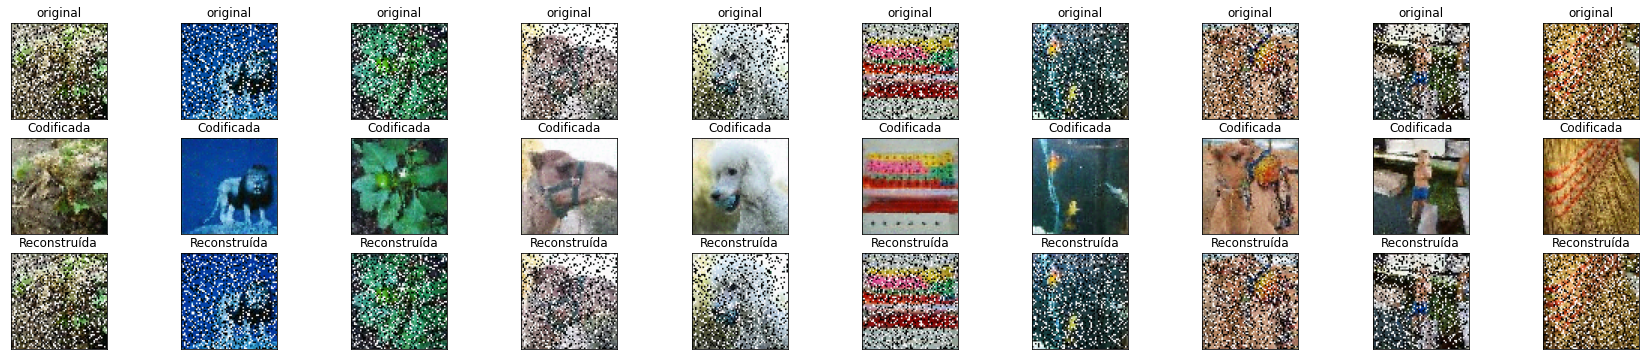

In [ ]:
n = 10
plt.figure(figsize=(30, 6))
for i in range(n):
  ax = plt.subplot(3, n, i + 1)
  plt.imshow(test_images[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  ax = plt.subplot(3, n, i + 1 + n)
  plt.imshow(encoded_imgs[i])
  plt.title("Codificada")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
    
  ax = plt.subplot(3, n, i + 1 + n + n)
  plt.imshow(decoded_imgs[i])
  plt.title("Reconstruída")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

plt.savefig('img_results.png')
plt.show()

<h3>Medidas de semelhanças entre a imagem original e a imagem com a mensagem escodida</h3>

In [ ]:
enc_set = encoded_imgs
enc_set = enc_set / 255
mseSum = 0
for i in range(test_images_original.shape[0]):
  mseSum += mean_squared_error(test_images_original[i], enc_set[i])
  
mseMean = mseSum / test_images_original.shape[0]

In [ ]:
mseMean

0.004171126889909468

<h3>Média de erro de bit na recuperação das mensagens secretas</h3>

In [ ]:
def erroBits(x, y):
  qtd = 0

  for i in range(x.shape[0]):
    if x[i] != y[i]:
      qtd += 1

  return qtd

In [ ]:
mediaErro = 0

j = 0

for i in decoded_imgs:
    a = np.array(i, copy=True)
    msgA = steganoInv(a)
    idxBitErro = corrigeHammerArray(msgA, nHammer)
    if idxBitErro > 0 and idxBitErro < len(msgA):
      msgA[idxBitErro - 1] = ~msgA[idxBitErro - 1] & 1
    
    erroValor = erroBits(test_messages[j], msgA)

    mediaErro += erroValor

    j += 1

mediaErro /= decoded_imgs.shape[0]

In [ ]:
mediaErro

0.58

<h3>Salva o dataset pós processado</h3>

In [ ]:
os.mkdir("dataset_original")

In [ ]:
os.mkdir("dataset_encoder")

In [ ]:
test_images_original *= 255
test_images_original = test_images_original.astype("uint8")

j = 0

for i in test_images_original:
  imsave("dataset_original/" + str(j) + ".png", i)
  j += 1

In [ ]:
encoded_imgs = encoded_imgs.astype("uint8")

j = 0

for i in encoded_imgs:
  imsave("dataset_encoder/" + str(j) + ".png", i)
  j += 1